In [1]:
import cv2 as cv
import numpy as np
from math import sin, cos, pi
from matplotlib import pyplot as plt


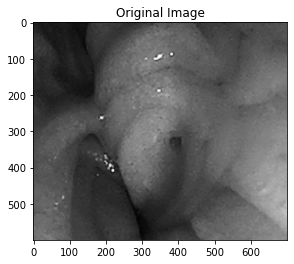

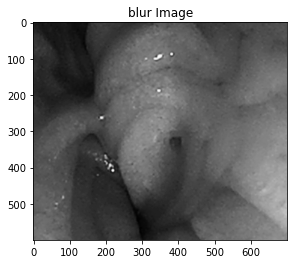

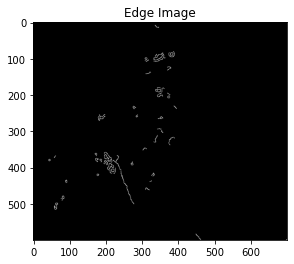

In [22]:
img = cv.imread('img/croped/001780.png',0)
blur = cv.GaussianBlur(img, (3, 3), 0)
edges = cv.Canny(blur, 50, 100)

plt.imshow(img,cmap='gray')
plt.title('Original Image')
plt.show()
plt.imshow(blur,cmap='gray')
plt.title('blur Image')
plt.show()
plt.imshow(edges,cmap='gray')
plt.title('Edge Image')
plt.show()

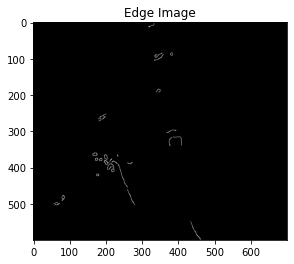

In [43]:
img = cv.imread('img/croped/001780.png', 0)

# create a CLAHE object
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
cl1   = clahe.apply(img)
blur  = cv.GaussianBlur(cl1, (15, 15), 0)
edges = cv.Canny(blur,50,100)

# plt.imshow(img, cmap='gray')
# plt.show()
# plt.imshow(cl1, cmap='gray')
# plt.show()
# plt.imshow(blur,cmap = 'gray')
# plt.title('blur Image')
# plt.show()
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image')
plt.show()

In [ ]:
'''
第一個引數是尋找輪廓的影象；

第二個參數列示輪廓的檢索模式，有四種（本文介紹的都是新的cv2介面）：
    cv2.RETR_EXTERNAL表示只檢測外輪廓
    cv2.RETR_LIST檢測的輪廓不建立等級關係
    cv2.RETR_CCOMP建立兩個等級的輪廓，上面的一層為外邊界，裡面的一層為內孔的邊界資訊。如果內孔內還有一個連通物體，這個物體的邊界也在頂層。
    cv2.RETR_TREE建立一個等級樹結構的輪廓。

第三個引數method為輪廓的近似辦法
    cv2.CHAIN_APPROX_NONE儲存所有的輪廓點，相鄰的兩個點的畫素位置差不超過1，即max（abs（x1-x2），abs（y2-y1））==1
    cv2.CHAIN_APPROX_SIMPLE壓縮水平方向，垂直方向，對角線方向的元素，只保留該方向的終點座標，例如一個矩形輪廓只需4個點來儲存輪廓資訊
    cv2.CHAIN_APPROX_TC89_L1，CV_CHAIN_APPROX_TC89_KCOS使用teh-Chinl chain 近似演算法
'''

# edges_copy = edges.copy()
# contours, hierarchy = cv.findContours(edges_copy, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# a = cv.drawContours(img,contours,0,(0,0,255),3)  

In [31]:
# img = cv.imread('img/croped/001780.png', 0)

# # create a CLAHE object
# clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
# cl1   = clahe.apply(img)
# blur  = cv.GaussianBlur(cl1, (21, 21), 0)
# edges = cv.Canny(blur,50,100)

# plt.imshow(img, cmap='gray')
# plt.show()
# plt.imshow(cl1, cmap='gray')
# plt.show()
# plt.imshow(blur,cmap = 'gray')
# plt.title('blur Image')
# plt.show()
# plt.imshow(edges,cmap = 'gray')
# plt.title('Edge Image')
# plt.show()

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable rint method

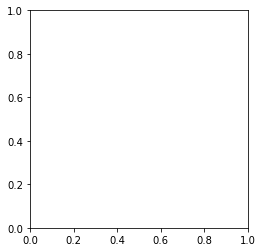

In [42]:
edgesCOPY = edges.copy()
circles = cv.HoughCircles(edgesCOPY,
                          cv.HOUGH_GRADIENT,
                          dp=8,
                          minDist=100,
                          param1=100,  #canny高的閥值(小的閥值就除以2)
                          param2=130,
                          minRadius=0,
                          maxRadius=50)


figure, axes = plt.subplots()
axes.set_aspect(1)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    axes.add_artist(plt.Circle((i[0],i[1]),
               i[2]+20,
               fill=False,
               color='red',
               linewidth=2
              ))
print(len(circles[0,:]))

plt.title('detect cycle')
plt.imshow(img, cmap = 'Greys_r')
plt.show()

# 以下是影像處理課程寫得

In [33]:
def cumulativeMatrix3D(edges, padding=2000):
    """
    :padding: padding the cumulative matrix record more information.
    :method:
        radius: >10
        angle : 0~360
        a = x - r * cos(angle*(pi/180))
        b = y - r * sin(angle*(pi/180))
    :return A:(a, b, radius) Cumulative Matrix
    """
    restore = padding//2
    
    radius = min(edges.shape[0], edges.shape[1])//2          # radius=minimum image length or width
    A      = np.zeros((edges.shape[0] + padding, edges.shape[1] + padding, radius))   # A padding=2000
    whiteIndexs = np.argwhere(edges == 255)                  # whiteIndexs:(x,y) gray scale=255 index 
    print("calculate point number:", len(whiteIndexs))
    
    # cumulative 
    n = 0
    for index in whiteIndexs:                     # (x,y)
        x, y = index[0], index[1]
        for r in range(20, radius):               # radius     
            for angle in range(360):        
                a = int(x - r * cos(angle*(pi/180)) + 0.5)            
                b = int(y - r * sin(angle*(pi/180)) + 0.5)
                
                if a >= A.shape[0] + restore:             # a, b bigger than padding
                    continue
                if b >= A.shape[1] + padding:
                    continue
                
                A[a + restore, b + restore, r] += 1
        
        if n%100==0:
            print("{} finish".format(n))
        n += 1
    return A

In [34]:
def lineInfo(A, cyclenumber=30):
    """
    Get the (rho, angle) of max value in cumulative matrix.
    
    :cyclenumber: number of line  
    :return: list [[a,b,r], [a,b,r]]
    """
    sortedvalue = np.sort(A, axis=None)[::-1][:cyclenumber]    
    abrs = []
    for sv in sortedvalue:
        abr = np.argwhere(A==sv)[0].tolist()
        if abr not in abrs:
            abrs.append(abr)

    return abrs

In [35]:
def deleteAdjacentCycle(abrs, diff=30):
    """
    Delete the adjacent Cycles.
    :method: if (a2 + b2 + r2)-(a1 + b1 + r1) < diff then delete cycle [a2,b2,r2].
    
    :diff: maximum difference
    :ras: [[a,b,r], [a,b,r]]
    :return: [[a,b,r], [a,b,r]]
    """
    
    wantdeletes = []
    sorted_abrs = sorted(abrs)
    for i in range(len(sorted_abrs)):
        for j in range(i+1, len(sorted_abrs)):
            if abs(sum(sorted_abrs[j]) - sum(sorted_abrs[i])) < diff:    # 
                wantdeletes.append(sorted_abrs[j])

    for wantdelete in wantdeletes:
        if wantdelete in sorted_abrs:
            sorted_abrs.remove(wantdelete)
    return sorted_abrs

In [44]:
padding = 1000
edges   = edges
A       = cumulativeMatrix3D(edges, padding=padding)

calculate point number: 967
0 finish
100 finish
200 finish
300 finish
400 finish
500 finish
600 finish
700 finish
800 finish
900 finish


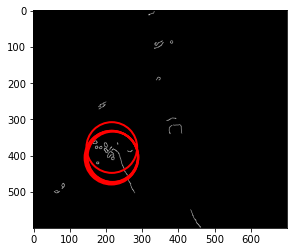

In [45]:
abrs         = lineInfo(A, cyclenumber=10)
sorted_abrs  = deleteAdjacentCycle(abrs, diff=2)

figure, axes = plt.subplots()
axes.set_aspect(1)
for abr in abrs:
    axes.add_artist(plt.Circle((abr[1]-padding//2, abr[0]-padding//2), 
                    abr[2]+50, 
                    fill=False, 
                    color='red', 
                    linewidth=2))
plt.imshow(edges, cmap='Greys_r')
plt.show()

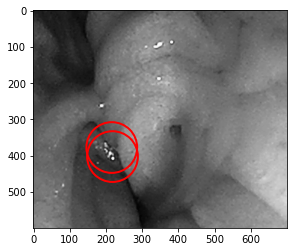

In [46]:
figure, axes = plt.subplots()
axes.set_aspect(1)
for abr in sorted_abrs:
    axes.add_artist(plt.Circle((abr[1]-padding//2, abr[0]-padding//2), 
                    abr[2]+50,   # 半徑+50
                    fill=False, 
                    color='red', 
                    linewidth=2))
plt.imshow(img, cmap='Greys_r')
plt.show()